# <center>WAE</center>

To do:
- Description
- Use same NN as in paper + with MSE loss + Gaussian prior
- Add WAE-GAN

In [1]:
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from tqdm.auto import trange
from sklearn.datasets import make_circles

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

### AutoEncoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_filter, d=48):
        super().__init__()
        self.num_filter = num_filter
        self.conv1 = nn.Conv2d(1, self.num_filter, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter, self.num_filter, 
                               kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv3 = nn.Conv2d(self.num_filter, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(self.num_filter*2, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*4, 
                               kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*4, self.num_filter*4,
                               kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, padding=1)        
        
        self.fc1 = nn.Linear(int(self.num_filter*4*4*4), 128)
        self.fc2 = nn.Linear(128, d)
                
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.pool1(F.leaky_relu(self.conv2(out), 0.2))
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.pool2(F.leaky_relu(self.conv4(out), 0.2))
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.pool3(F.leaky_relu(self.conv6(out), 0.2))
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
    

class Decoder(nn.Module):
    def __init__(self, num_filter, bottleneck_size=48):
        super().__init__()
        self.num_filter = num_filter

        self.fc4 = nn.Linear(bottleneck_size, 128)
        self.fc5 = nn.Linear(128, self.num_filter*4*4*4)
        
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(self.num_filter*4, self.num_filter*2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*2, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        d = self.num_filter
        out = torch.relu(self.fc5(self.fc4(x)))
        out = out.view(-1, 4*d, 4, 4)
        
        out = F.leaky_relu(self.conv1(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(self.upsample(out)), 0.2)

        out = torch.sigmoid(self.conv6(out))
        return out
    
    
class AE(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.encoder = Encoder(input_shape, d)
        self.decoder = Decoder(input_shape, d)
    
    def forward(self, x):
        z = self.encoder(x)        
        y = self.decoder(z)
        return y

In [5]:
## https://github.com/eifuentes/swae-pytorch/blob/763f771c1d4860f71819af48d4f21a8a29a689d5/swae/distributions.py#L38

def rand_ring2d(batch_size):
    """ This function generates 2D samples from a hollowed-cirlce distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    circles = make_circles(2 * batch_size, noise=.01)
    z = np.squeeze(circles[0][np.argwhere(circles[1] == 0), :])
    return torch.from_numpy(z).type(torch.FloatTensor)


def rand_circle2d(batch_size):
    """ This function generates 2D samples from a filled-circle distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    r = np.random.uniform(size=(batch_size))
    theta = 2 * np.pi * np.random.uniform(size=(batch_size))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.array([x, y]).T
    return torch.from_numpy(z).type(torch.FloatTensor)

In [6]:
def val_mnist(model, latent_dim=2, latent_distr="unif"):
    model.eval()

    torch.manual_seed(42)
    r,c = 5,5
    if latent_distr == "unif":
        z = -1+2*torch.rand(r*c, latent_dim, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         z = F.normalize(g, p=2, dim=1)
        z = rand_ring2d(r*c).to(device)
    elif latent_distr == "circle":
        z = rand_circle2d(r*c).to(device)
        
    gen_imgs = model.decoder(z).reshape(-1,28,28).detach().cpu()

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs[cpt],"gray")
            ax[i,j].axis('off')

            cpt += 1
                
    fig.set_size_inches(6, 6)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_latent(model, test_loader):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())
    
    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    
    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets

    plt.figure(figsize=(10,10))
    plt.scatter(z[:,0], -z[:,1], c=10*Y, cmap=plt.cm.Spectral)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.show()

In [9]:
def train(model, optimizer, n_epochs, train_loader, test_loader, latent_distr="unif", plot_val=False):
    pbar = trange(n_epochs)

    losses = []
    val_losses = []

    for e in pbar:
        loss_epoch = 0
        cpt_batch = 0

        for x_batch, _ in train_loader:
            x_batch = x_batch.to(device)

            model.train()

            z_hat = model.encoder(x_batch)
            y_hat = model.decoder(z_hat)

            l = ae_loss(x_batch, y_hat, z_hat, latent_distr)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_epoch += l.item()/x_batch.size(0)
            cpt_batch += 1

        losses.append(loss_epoch/cpt_batch)

        loss_val_epoch = 0
        cpt_batch = 0

        with torch.no_grad():
            for x_val, _ in test_loader:
                x_val = x_val.to(device)

                model.eval()
                zhat = model.encoder(x_val)
                yhat = model.decoder(zhat)
                val_l = ae_loss(x_val,yhat,zhat,latent_distr)
                loss_val_epoch += val_l.item()/x_val.size(0)
                cpt_batch += 1

            val_losses.append(loss_val_epoch/cpt_batch)

        print(e,losses[-1],val_losses[-1])

        if e%10 == 0 and plot_val:  
            with torch.no_grad():
                model.eval()
                for x_val, _ in test_loader:
                    fig,ax = plt.subplots(1,2,figsize=(10,10))

                    ax[0].imshow(x_val[0][0],"gray")

                    x_val = x_val.to(device)

                    model.eval()
                    yhat = model(x_val[0][0].reshape(-1,28,28))
                    yhat = yhat.reshape(-1,1,28,28)
                    ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
                    plt.show()

                    break

                plot_latent(model, test_loader)
                
    if plot_val:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()
        plt.show()


### WAE-MMD

In [137]:
def train(model, optimizer, n_epochs, train_loader, test_loader, latent_distr="unif", plot_val=False):
    pbar = trange(n_epochs)

    losses = []
    val_losses = []

    for e in pbar:
        loss_epoch = 0
        cpt_batch = 0

        for x_batch, _ in train_loader:
            x_batch = x_batch.to(device)

            model.train()

            z_hat = model.encoder(x_batch)
            y_hat = model.decoder(z_hat)

            l = ae_loss(x_batch, y_hat, z_hat, latent_distr)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_epoch += l.item()/x_batch.size(0)
            cpt_batch += 1

        losses.append(loss_epoch/cpt_batch)

        loss_val_epoch = 0
        cpt_batch = 0

        with torch.no_grad():
            for x_val, _ in test_loader:
                x_val = x_val.to(device)

                model.eval()
                zhat = model.encoder(x_val)
                yhat = model.decoder(zhat)
                val_l = ae_loss(x_val,yhat,zhat,latent_distr)
                loss_val_epoch += val_l.item()/x_val.size(0)
                cpt_batch += 1

            val_losses.append(loss_val_epoch/cpt_batch)

        print(e,losses[-1],val_losses[-1])

        if e%10 == 0 and plot_val:  
            with torch.no_grad():
                model.eval()
                for x_val, _ in test_loader:
                    fig,ax = plt.subplots(1,2,figsize=(10,10))

                    ax[0].imshow(x_val[0][0],"gray")

                    x_val = x_val.to(device)

                    model.eval()
                    yhat = model(x_val[0][0].reshape(-1,28,28))
                    yhat = yhat.reshape(-1,1,28,28)
                    ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
                    plt.show()

                    break

                plot_latent(model, test_loader)
                
    if plot_val:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()
        plt.show()


In [136]:
criterion = nn.BCELoss(reduction='mean')

def gaussian_kernel(x, y, h):
    return torch.exp(-torch.cdist(x,y)**2/h)

def imq(x, y, h):
    return h/(h+torch.norm(x.unsqueeze(1) - y.unsqueeze(0), dim=-1) ** 2)
#     return h/(h+torch.cdist(x,y)**2)



def mmd(x, y, kernel, h):
    ## Unbiased estimate
    Kxx = kernel(x, x, h)
    Kyy = kernel(y, y, h)
    Kxy = kernel(x, y, h)

    n = x.shape[0]
    cpt1 = (torch.sum(Kxx)-torch.sum(Kxx.diag()))/(n-1) ## remove diag terms
    cpt2 = (torch.sum(Kyy)-torch.sum(Kyy.diag()))/(n-1)
    cpt3 = torch.sum(Kxy)/n

    return (cpt1+cpt2-2*cpt3)/n
    

def ae_loss(x, y, z, latent_distr="unif"):
    n, d = z.size()
    
    if latent_distr == "unif":
        target_latent = -1+2*torch.rand(n, d, device=device)
    elif latent_distr == "ring":
        target_latent = rand_ring2d(n).to(device)
    elif latent_distr == "circle":
        target_latent = rand_circle2d(n).to(device)
    
    h = 2 * d
    l_latent = mmd(z, target_latent, imq, h)
    reconstruction_loss = criterion(y, x)
        
    return reconstruction_loss+10.0*l_latent

#### Latent=Unif

  0%|          | 0/101 [00:00<?, ?it/s]

0 0.0016396993180116015 0.024461213302926513


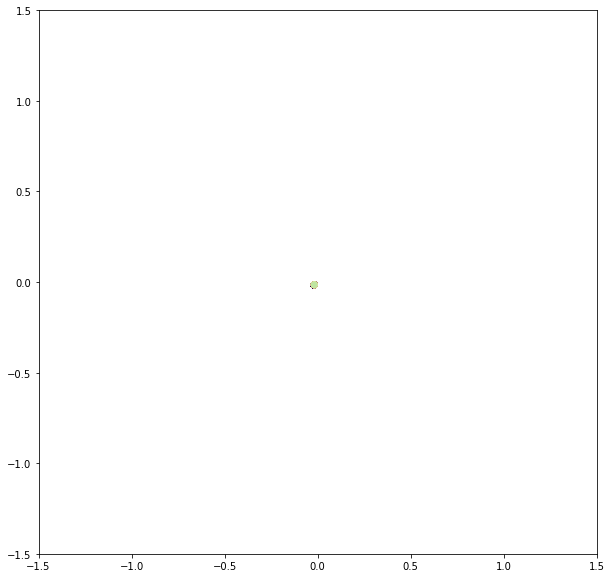

1 0.0015498147974411646 0.024297356409148665
2 0.0015538736591736468 0.024415816957006058
3 0.0015490928421417873 0.024178812072014274
4 0.0015520611683527631 0.024550252909453722
5 0.001552662450075149 0.02451750045172132
6 0.0015468000620603552 0.024565141433820176
7 0.001556758718689283 0.02477170262759486
8 0.0015619149367014568 0.024683020491236315
9 0.0015581014096736907 0.02432284990962321
10 0.0015509122212727863 0.024251748370333982


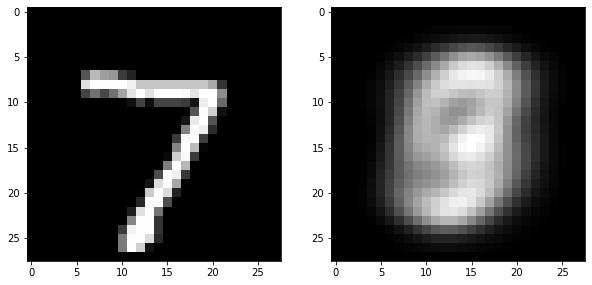

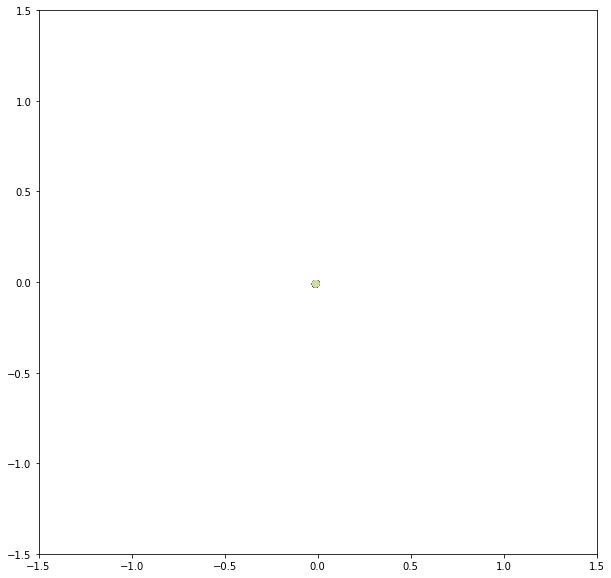

11 0.0015509790201981859 0.024279224510771778
12 0.0015577568362156553 0.024553816899443016
13 0.0015508285184701288 0.024077749748627978
14 0.0015534282883008321 0.024425611572381788
15 0.0015478860567013433 0.023944969095599157
16 0.001557852501670519 0.024455013476645412
17 0.0015542069554328923 0.02455842521743843
18 0.0015482414891322455 0.02420555349713126
19 0.0015529930005470911 0.0243955629940231
20 0.0015534595787525178 0.024397910236360166


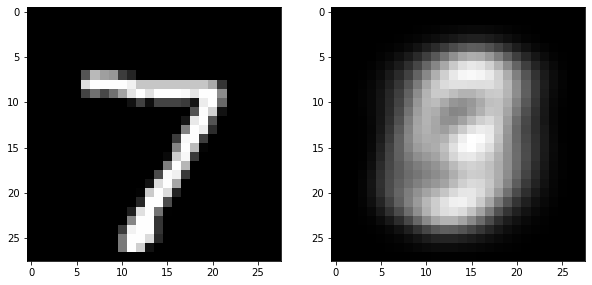

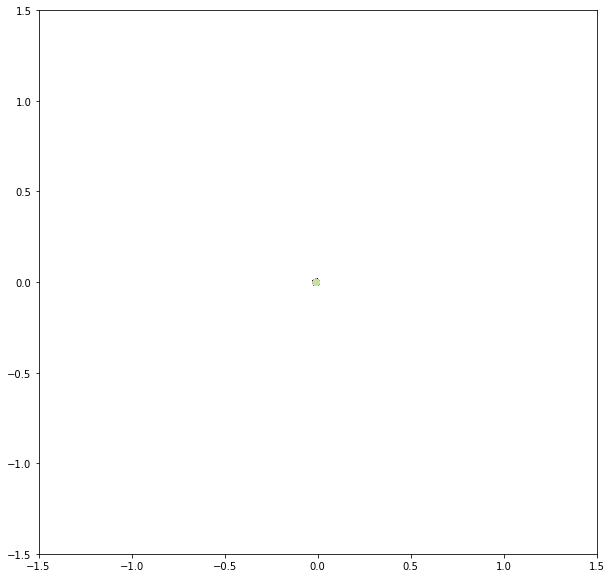

21 0.0015525084783633554 0.024425906048843656
22 0.0015576097935438157 0.024177434720313206
23 0.0015595958222945534 0.02478752149560581
24 0.0015557377199331925 0.024211851838297736
25 0.0015493775129318246 0.024301383004616053
26 0.001548878511786461 0.024349819630765306
27 0.0015475930005311965 0.024267484181033916
28 0.001548405454556147 0.024202295944999203
29 0.0015517488559087125 0.024275490395224895
30 0.0015568739920854562 0.024448125203625083


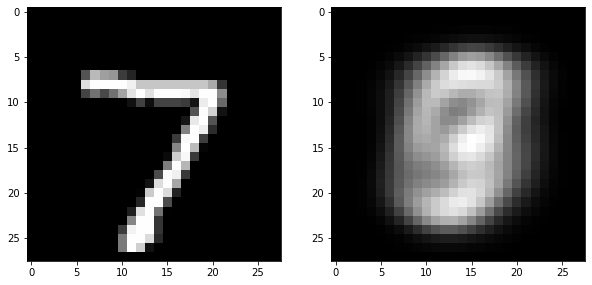

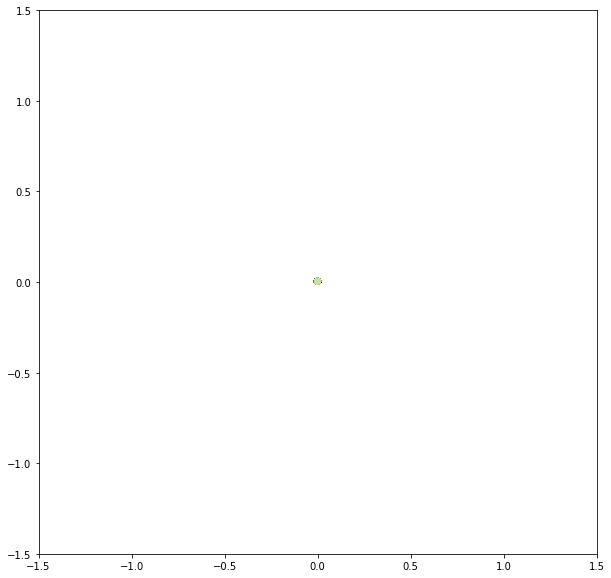

31 0.0015496384441852573 0.02440060277026111
32 0.001553331752618154 0.024238486878407267
33 0.001163306453824043 0.01843632046228495
34 0.0005526084008316199 0.014667631238520431
35 0.0005341896327833333 0.014274732333224136
36 0.0005100906918446224 0.01413459937198284
37 0.0005076047576963902 0.013631256731649556
38 0.000505659978091717 0.014567007535336593
39 0.0005012884559730687 0.013696398510160251
40 0.0005044739169379075 0.013548589308564655


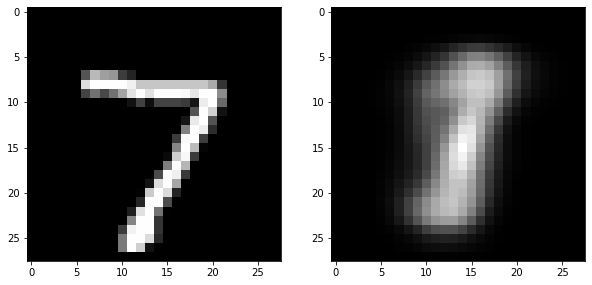

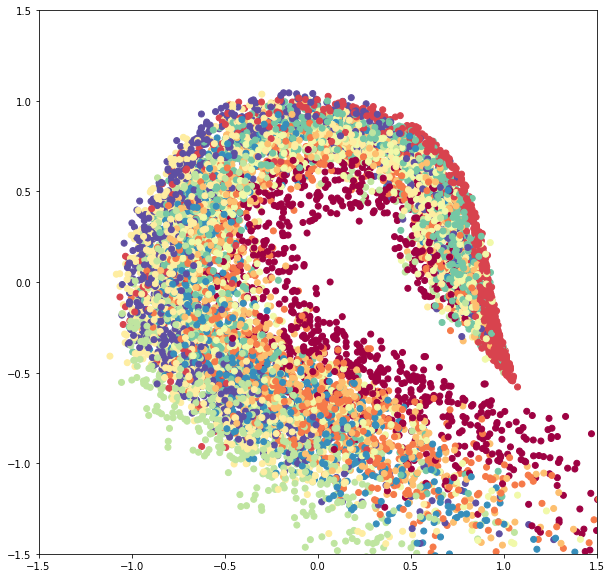

41 0.0004884029512604078 0.013286670854392524
42 0.000482484522461891 0.012135377905060784
43 0.00048416591559847193 0.012852955911570369
44 0.0004786730493108433 0.012470092561940987
45 0.0004828849487006667 0.012367862730492323
46 0.0004725021392107008 0.011439203388822346
47 0.00046766433790326116 0.01116748109977609
48 0.00047056220099329953 0.01124281872706577
49 0.00046913784990708043 0.0107138164418812
50 0.00045650995150208477 0.01004376677355875


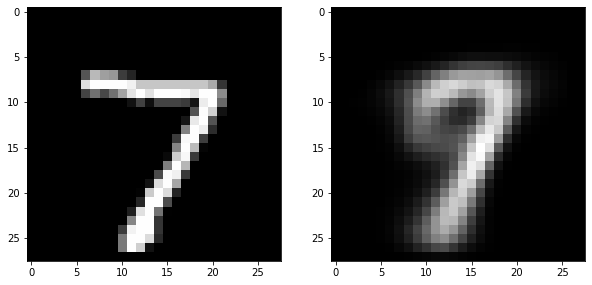

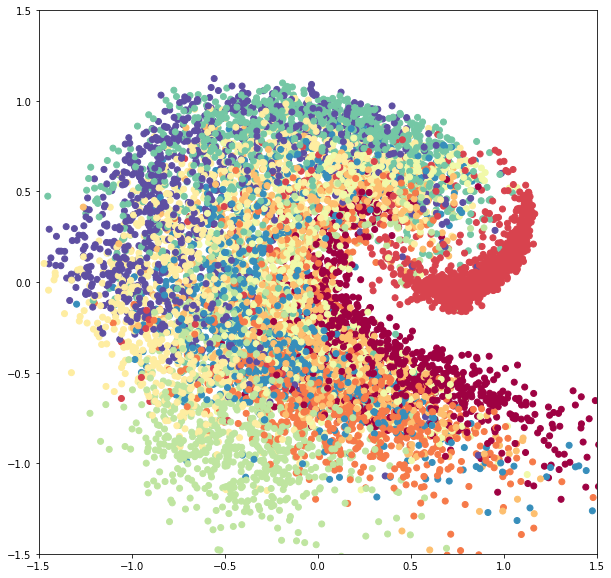

51 0.0004644916445016862 0.010742009123459982
52 0.0004392459986110528 0.009063034754294081
53 0.00044466688285271327 0.008603336067852406
54 0.0004381320945918559 0.008756673762414116
55 0.00042047468150655426 0.008371493982942626
56 0.0004180969285468261 0.007813823030005914
57 0.0004179560626546539 0.008374755632298917
58 0.0004074624905983607 0.008136718660390702
59 0.0004089906029403209 0.007635811373543816
60 0.0004024574677149456 0.00796800562606071


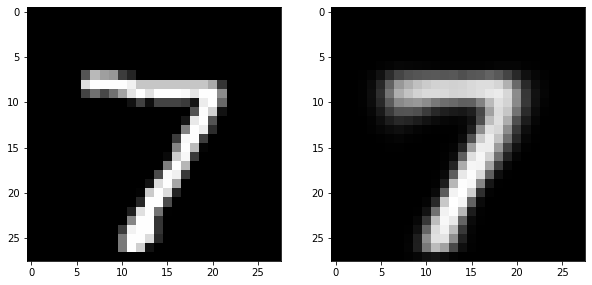

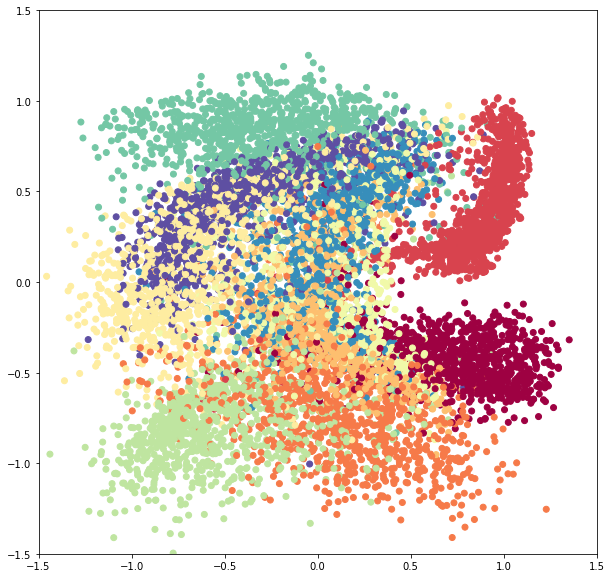

61 0.0004046061133344969 0.008287947784109522
62 0.0003961152044435341 0.007712991351779467
63 0.00039147070695956553 0.00789837818146466
64 0.0003976152506967387 0.007981293494054399
65 0.00038916064575314523 0.0072157289803075715
66 0.00038823512122035045 0.007414200761245367
67 0.00038476623222231845 0.007281290048870226
68 0.0003846140362322329 0.007487941275948819
69 0.0003771217477818329 0.007624724619507123
70 0.00038929293627540287 0.007424576517444449


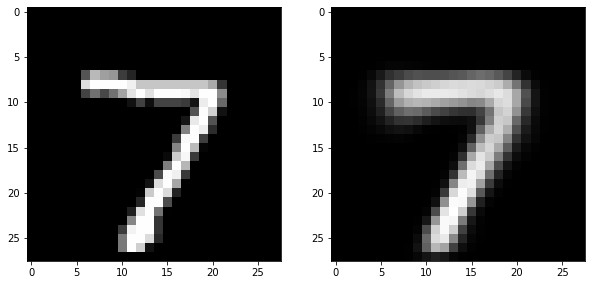

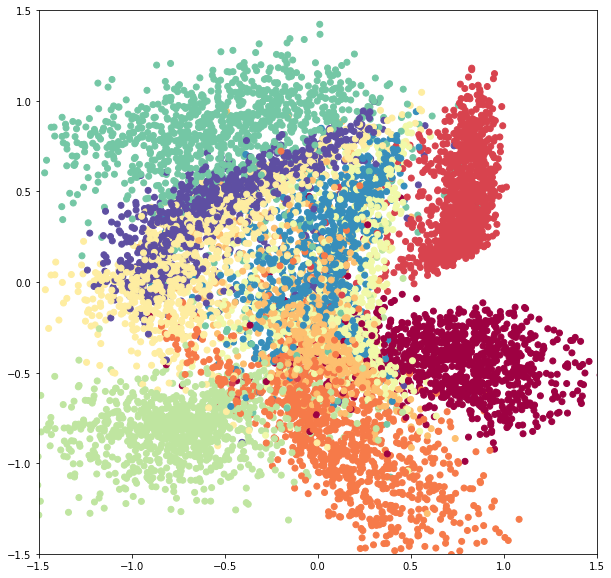

71 0.00038322516555587457 0.0071912889633649075
72 0.00037427753483255705 0.007320588601889988
73 0.0003796862378716468 0.0069859787768211225
74 0.00037404111002882316 0.007569690382244964
75 0.00036768861263990394 0.007004505805909253
76 0.0003657700988153616 0.0073820166914655375
77 0.0003664699099957944 0.007165765104154809
78 0.00036737270454565677 0.006830115635959676
79 0.0003640380623439947 0.006680284812748908
80 0.00036359524081150683 0.007264548216384059


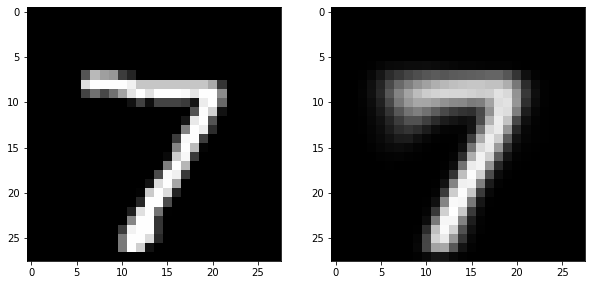

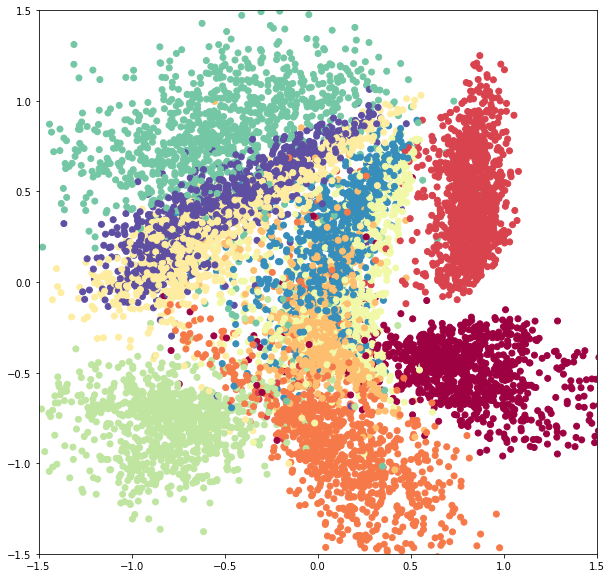

81 0.0003670337637265524 0.006927082814966528
82 0.00036674849192301444 0.006875348885873922
83 0.00036459350387255357 0.007166328665892632
84 0.0003571387946605683 0.006748328308244578
85 0.00036066377510627127 0.007230975549108685
86 0.0003564284714559714 0.006503867044949684
87 0.00035946217998862276 0.006729579868372351
88 0.00036348443652192756 0.006772246533118117
89 0.00036320193807284033 0.006997086351719527
90 0.0003583785576124987 0.006741796263133566


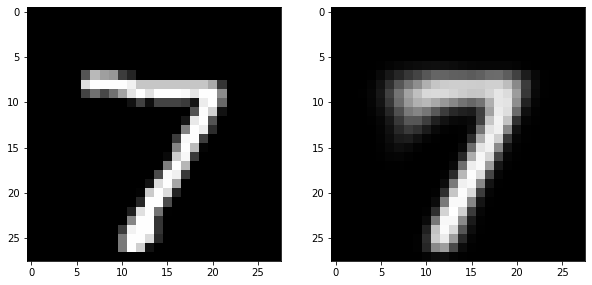

91 0.00035883859023451805 0.00679816423614804
92 0.0003533477559685706 0.0066362623878109
93 0.00035349195326368017 0.006727537247367179
94 0.0003543258386353652 0.006415125591079362
95 0.00035402573148409525 0.007187191675158259
96 0.00035284370308121037 0.007154348971375737
97 0.00035369978596766776 0.006730846461122885
98 0.00035052366455396025 0.007040066506189946
99 0.0003553582541644575 0.006613695492652563
100 0.000352570359657208 0.006714998626897034


In [138]:
model = AE(16, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, 101, train_loader, test_loader, "unif", True)

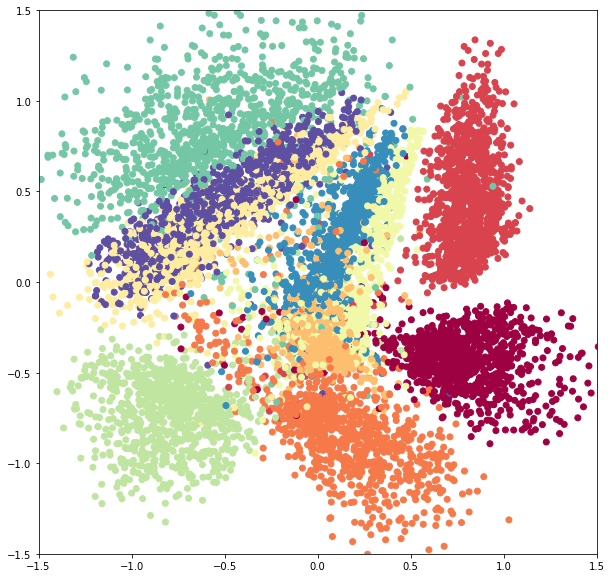

In [139]:
plot_latent(model, test_loader)

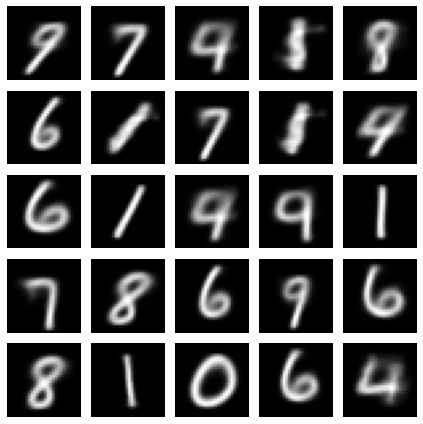

In [140]:
val_mnist(model)

In [141]:
criterion = nn.BCELoss(reduction='mean')

def gaussian_kernel(x, y, h):
    return torch.exp(-torch.cdist(x,y)**2/h)

def imq(x, y, h):
    return h/(h+torch.norm(x.unsqueeze(1) - y.unsqueeze(0), dim=-1) ** 2)


def mmd(x, y, kernel, h):
    ## Unbiased estimate
    Kxx = kernel(x, x, h)
    Kyy = kernel(y, y, h)
    Kxy = kernel(x, y, h)
        
    n = x.shape[0]
    cpt1 = (torch.sum(Kxx)-torch.sum(Kxx.diag()))/(n-1) ## remove diag terms
    cpt2 = (torch.sum(Kyy)-torch.sum(Kyy.diag()))/(n-1)
    cpt3 = torch.sum(Kxy)/n

    return (cpt1+cpt2-2*cpt3)/n
    

def ae_loss(x, y, z, latent_distr="unif"):
    n, d = z.size()
    
    if latent_distr == "unif":
        target_latent = -1+2*torch.rand(n, d, device=device)
    elif latent_distr == "ring":
        target_latent = rand_ring2d(n).to(device)
    elif latent_distr == "circle":
        target_latent = rand_circle2d(n).to(device)

#     sw = sliced_wasserstein(z, target_latent, 1000, device, p=2)
    
    h = 2 * d
    loss_latent = mmd(z, target_latent, imq, h)
    
#     reconstruction_loss = criterion(y, x)
    
    reconstruction_loss = F.mse_loss(y.reshape(x.shape[0], -1), x.reshape(x.shape[0], -1), 
                                     reduction="none").sum(dim=-1).mean(dim=0)
    
        
    return reconstruction_loss+10.0*loss_latent

  0%|          | 0/101 [00:00<?, ?it/s]

0 0.18402462755839036 2.8207470578507494


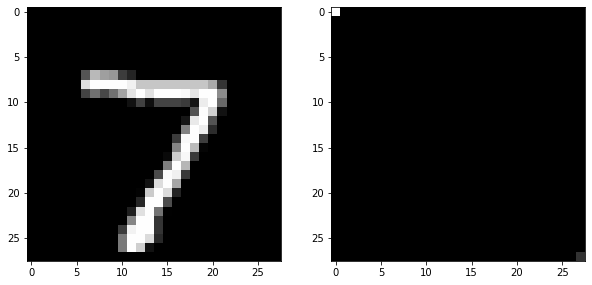

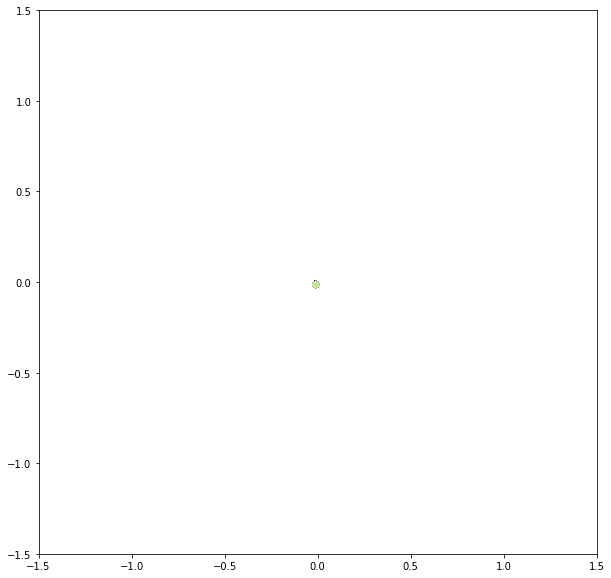

1 0.1766431879679362 2.8205650382148573
2 0.17664739468892413 2.8207421535120223
3 0.17664253082275394 2.8205000424918274
4 0.1766458609263102 2.820880960732603
5 0.17664663530985514 2.82084449297323
6 0.17664076665242517 2.820897909779899
7 0.1766507511138916 2.8211001458640297
8 0.17665049807230646 2.820871209184202
9 0.17665088170369472 2.8206096335340995
10 0.17664397850036612 2.8205885932849237


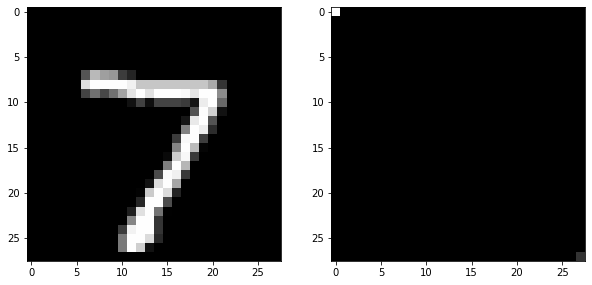

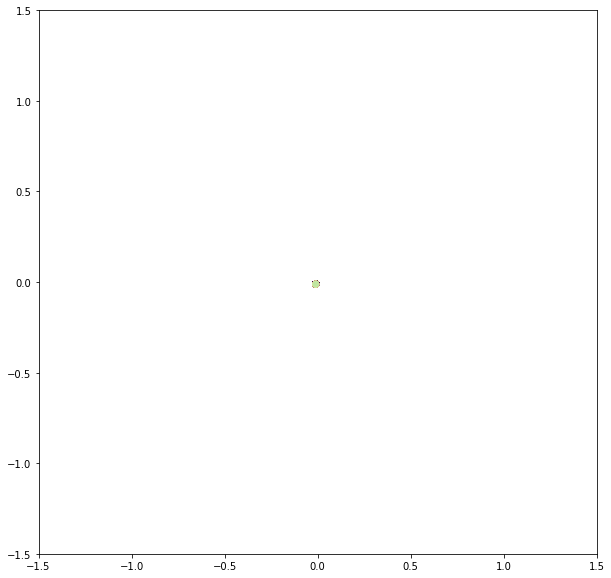

11 0.17664461924235034 2.8206020483193686
12 0.17665160268147792 2.820885204278623
13 0.17664472821553553 2.8204092937536513
14 0.1766473668416341 2.8207566654339384
15 0.1766420743306478 2.8202708277839443
16 0.17665179862976074 2.8207820330184106
17 0.1766481728871664 2.8208882104093655
18 0.17664229596455897 2.820534829514476
19 0.17664700546264644 2.8207034108737785
20 0.17664758224487306 2.820725709866411


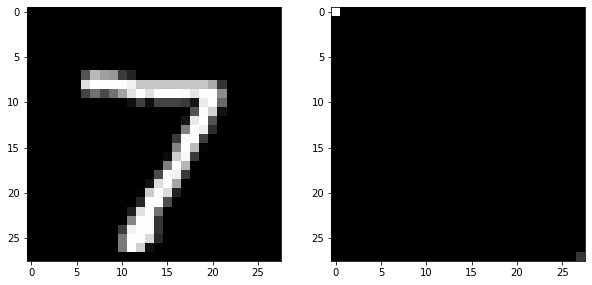

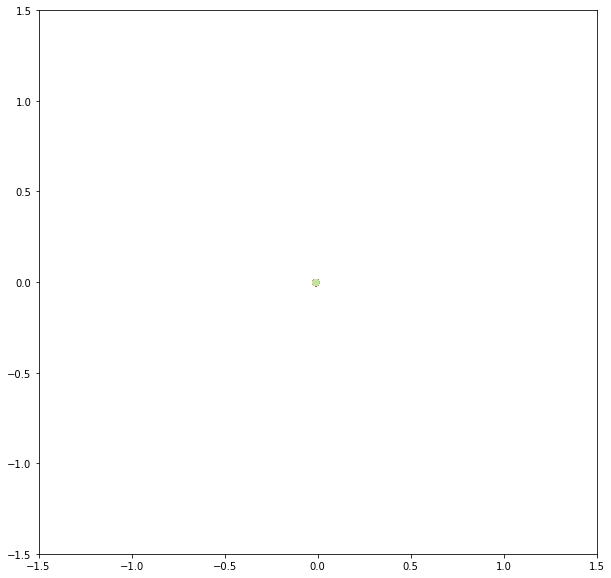

21 0.1766467583974202 2.8207588645215993
22 0.17665179061889635 2.8205087817134187
23 0.17665387713114425 2.82111573942934
24 0.17664992256164552 2.8205343728629164
25 0.17664353764851892 2.8206306124647584
26 0.17664313519795727 2.820680707788315
27 0.17664163017272944 2.8205906072744544
28 0.1766426534016927 2.820537621982562
29 0.17664585851033526 2.8206102627153977
30 0.17665138664245608 2.8207848479572575


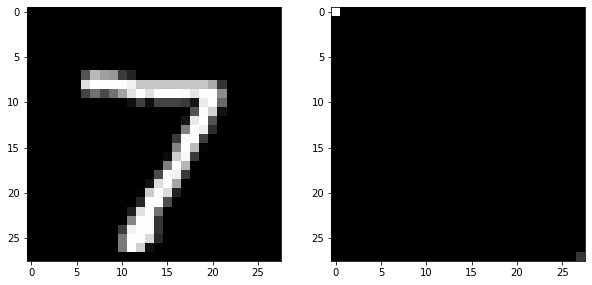

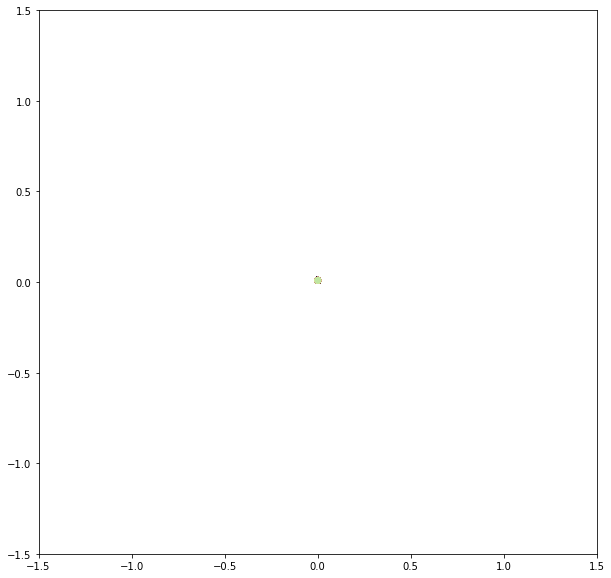

31 0.17664362208048515 2.820715815495378
32 0.1766474939982097 2.820622646770538
33 0.17664316279093428 2.8205390921035134
34 0.1766450583140056 2.8202900147666567
35 0.17664871762593587 2.820372825613418
36 0.17663959910074867 2.82043171957278
37 0.17664582417805982 2.82083057519346
38 0.17664031982421868 2.8205991111243494
39 0.17664502792358397 2.8204407154942475
40 0.176650541305542 2.8204179385218757


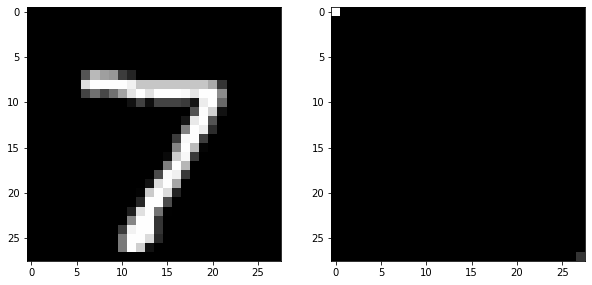

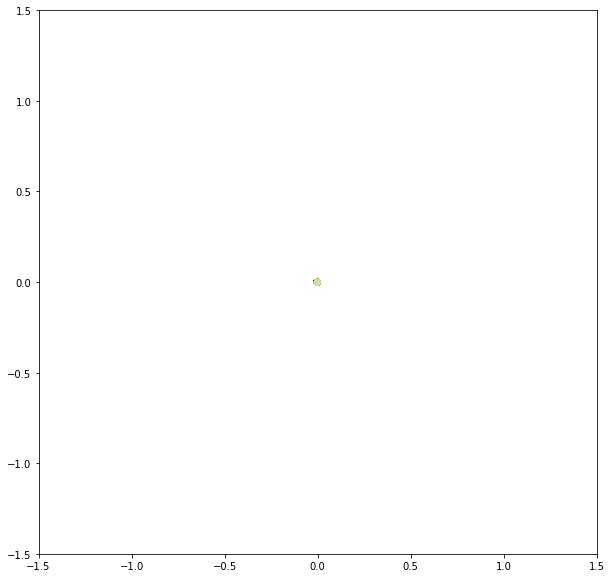

41 0.17665023867289226 2.8210418559491823
42 0.17664056905110667 2.8204085807830763
43 0.17664501164754232 2.820677729460378
44 0.17664435450236002 2.820645247404568
45 0.17664799575805656 2.8206722165068117
46 0.1766504456837972 2.820861367371897
47 0.17665001538594577 2.820434270956265
48 0.17664661191304526 2.8205948150196014
49 0.1766447959899902 2.820185343297526
50 0.17664064470926916 2.8204826665000793


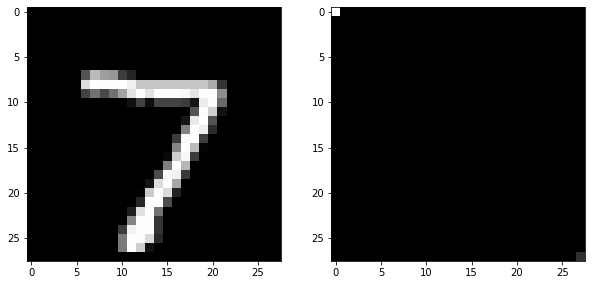

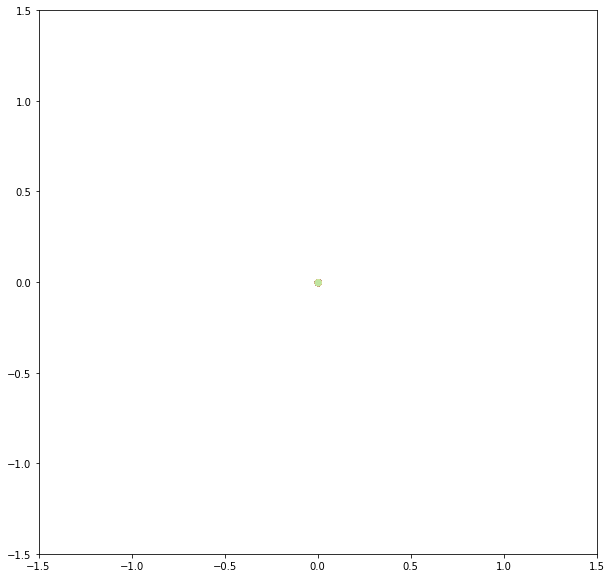

51 0.1766455418904621 2.8206128342844807
52 0.17664575958251955 2.8207519397187157
53 0.17664424756368 2.820638728217957
54 0.17664658012390133 2.820762685693491
55 0.17664687143961597 2.8204866560122457
56 0.176638959757487 2.820575022849793
57 0.17664471918741861 2.8209265714255385
58 0.17664695002237957 2.820557834622197
59 0.17664108759562178 2.8205574777560494
60 0.17664460436503102 2.8210184985456377


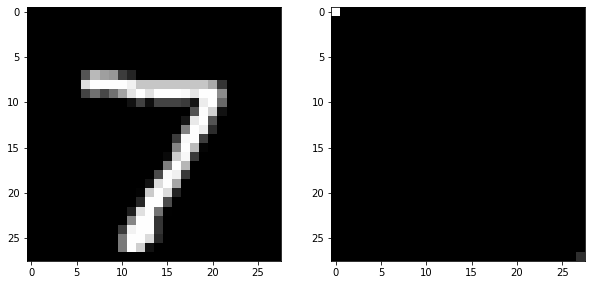

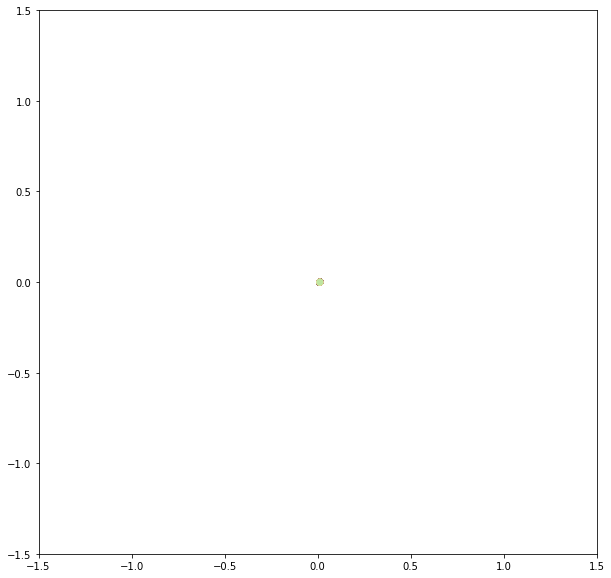

61 0.17665064748128265 2.820763103497295
62 0.176647901280721 2.820555663337342
63 0.1766437867482503 2.8210144328614013
64 0.17664872589111327 2.820834652303507
65 0.17664435056050615 2.8208403408336946
66 0.17665337041219079 2.820658409176543
67 0.17664873402913406 2.8207812971962145
68 0.17665463282267257 2.8207512800685897
69 0.17664316507975253 2.8204241724440844
70 0.17664983202616377 2.820608386978174


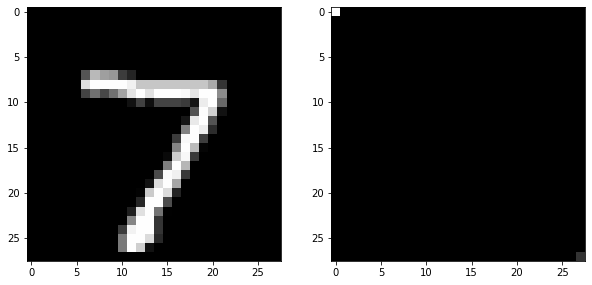

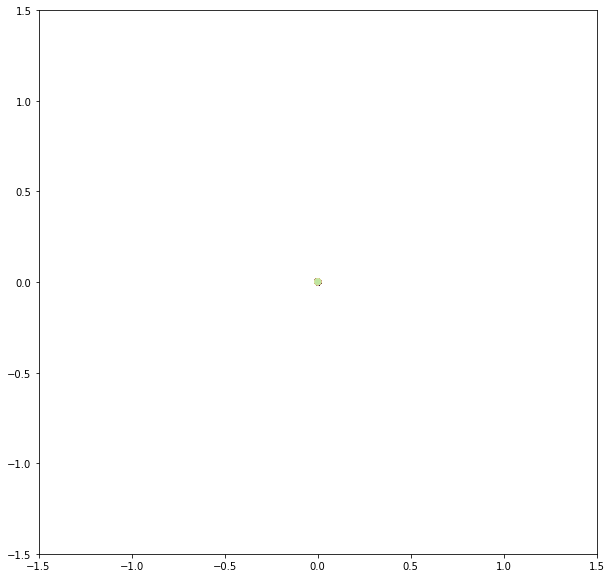

71 0.1766421049753826 2.8208450615977325
72 0.17664490814208988 2.820435804680894
73 0.17664446868896483 2.820675505997655
74 0.17664673283894858 2.8206361661703823
75 0.1766407624562582 2.820593955798652
76 0.17664197909037269 2.8209666977294336
77 0.17664472757975258 2.8207809803204036
78 0.1766490456899007 2.8204384836525964
79 0.1766480261484782 2.8203204276081855
80 0.1766446455637614 2.8204430455978686


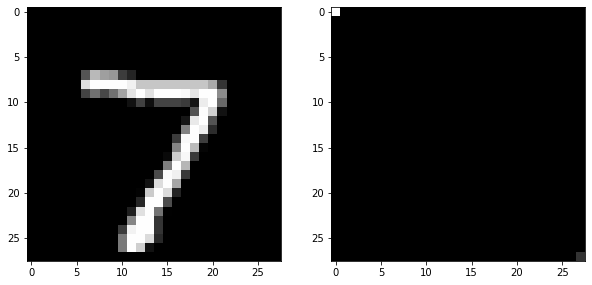

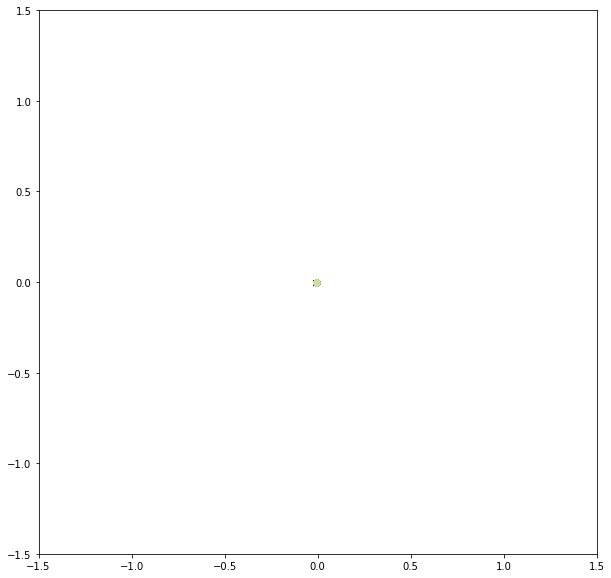

81 0.17664800682067866 2.820841971677713
82 0.17663665822347008 2.8132017222456276
83 0.1757165835062663 2.808718550700349
84 0.17566707382202146 2.808856473563197
85 0.17565041898091635 2.8077143586862583
86 0.175651907602946 2.8094547819405697
87 0.17565187670389806 2.8081277525082182
88 0.17564116096496585 2.8073721053882146
89 0.17564004109700518 2.808053014758296
90 0.1756404820760091 2.8076999636884694


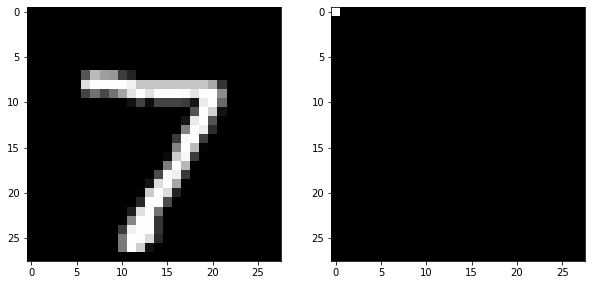

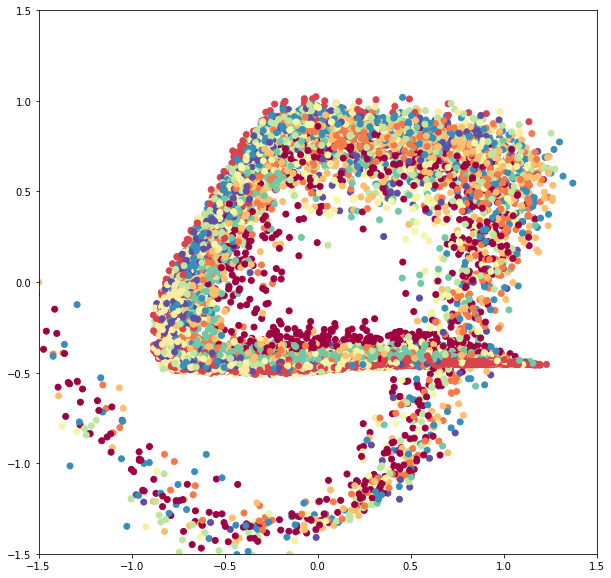

91 0.1756489377339681 2.8084582174167085
92 0.17564337170918773 2.807733452739045
93 0.17563720143636055 2.8070506855321766
94 0.17563221537272133 2.8073701211057913
95 0.17563885726928713 2.807934072832711
96 0.17563836835225424 2.807281796543743
97 0.17563653132120766 2.8069809907541488
98 0.17563867518107104 2.807858777884096
99 0.17564041188557938 2.8073001543934732
100 0.1756379763285319 2.807229703988511


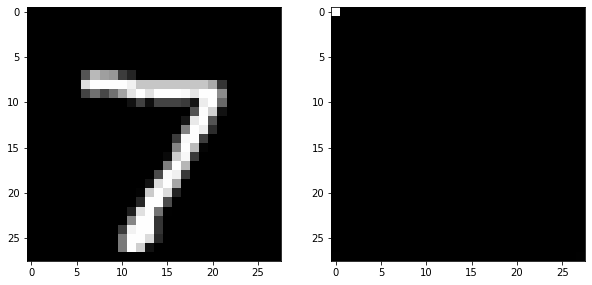

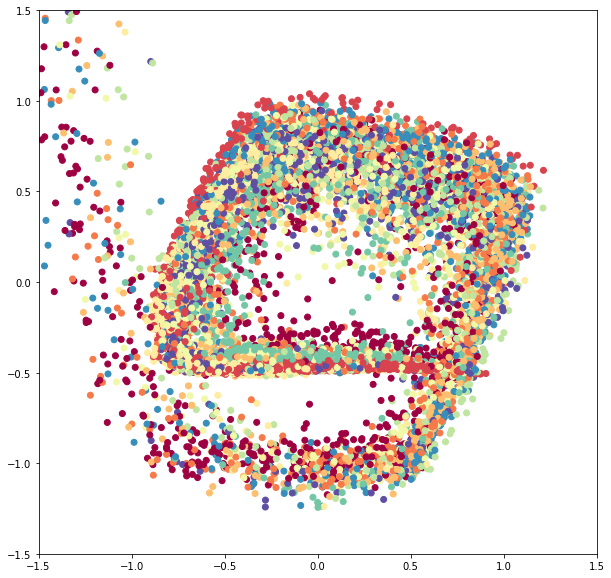

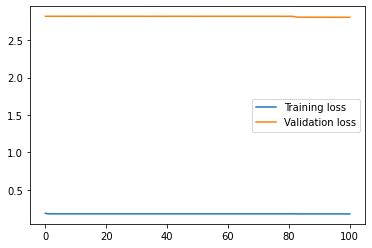

In [142]:
model = AE(16, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, 101, train_loader, test_loader, "unif", True)

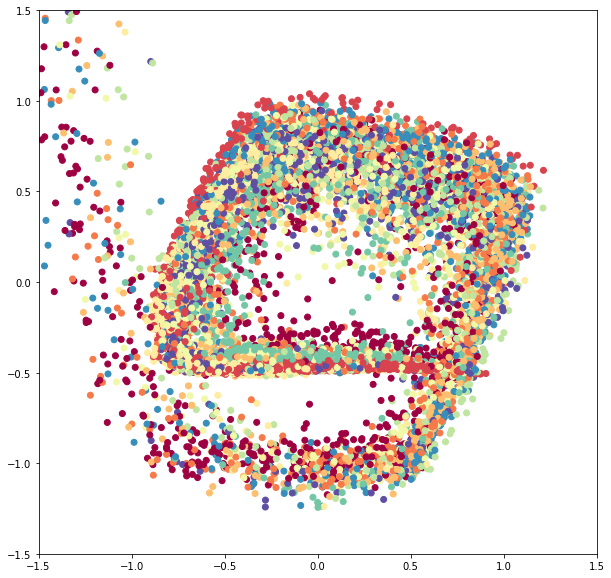

In [143]:
plot_latent(model, test_loader)

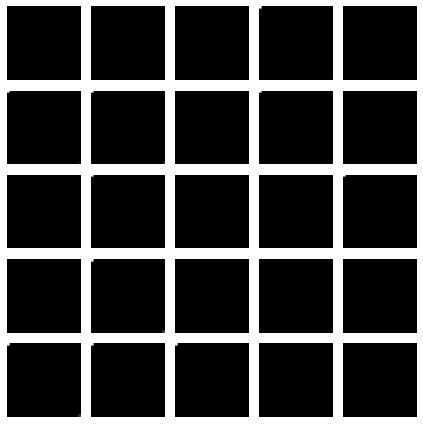

In [144]:
val_mnist(model)